In [9]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
%matplotlib inline

In [10]:
FEATURE_DIR = r"data\features_scored_4levels"   # folder produced by the improved feature extraction notebook
FEATURE_CSV = os.path.join(FEATURE_DIR, "features_master.csv")
OUT_DIR = r"data\gmm_benchmark"
os.makedirs(OUT_DIR, exist_ok=True)

N_COMPONENTS_PCA = 3          # for visualization / optional dimensionality reduction
GMM_COMPONENTS = 4            # you chose 4 clusters
RANDOM_STATE = 42

# Which columns to use for composite score & clustering (tweakable).
# We'll automatically select sensible subsets: power-like, freq, timing, symmetry, coact, consistency candidates.
AUTO_FEATURE_KEYWORDS = [
    "__rms", "__peak", "__iEMG", "__mnf", "__mdf", "__time_to_peak", "__dur_halfmax",
    "__mrms_mean", "__mrms_peak", "coact", "LR_mean_ratio", "__std", "__wl"
]

# Name of output benchmark JSON
BENCHMARK_JSON = os.path.join(OUT_DIR, "benchmark_gmm_4clusters.json")
print("FEATURE_CSV:", FEATURE_CSV)
print("OUT_DIR:", OUT_DIR)

FEATURE_CSV: data\features_scored_4levels\features_master.csv
OUT_DIR: data\gmm_benchmark


In [11]:
# Cell 2 - load feature table and build candidate feature matrix
df = pd.read_csv(FEATURE_CSV)
print("Loaded features:", df.shape)
print("Columns available (first 80):")
print(df.columns.tolist()[:80])

# Drop rows with too few samples if QC exists
if 'n_samples' in df.columns:
    df = df[df['n_samples'] >= 10].reset_index(drop=True)

# Build list of candidate feature columns based on keywords
candidate_cols = []
for col in df.columns:
    for kw in AUTO_FEATURE_KEYWORDS:
        if kw.lower() in col.lower():
            candidate_cols.append(col)
            break
candidate_cols = sorted(list(set(candidate_cols)))
print("Auto-selected candidate features (count):", len(candidate_cols))
print(candidate_cols[:50])

# If no candidates found, fallback to most numeric columns excluding metadata
if len(candidate_cols) == 0:
    exclude = {'file','player','n_samples','fs_used'}
    candidate_cols = [c for c in df.columns if c not in exclude and np.issubdtype(df[c].dtype, np.number)]
    print("Fallback candidate features count:", len(candidate_cols))


Loaded features: (5, 194)
Columns available (first 80):
['file', 'player', 'n_samples', 'fs_used', 'Rectus Femoris right__mean', 'Rectus Femoris right__std', 'Rectus Femoris right__rms', 'Rectus Femoris right__rms_rel', 'Rectus Femoris right__mav', 'Rectus Femoris right__mav_rel', 'Rectus Femoris right__wl', 'Rectus Femoris right__peak', 'Rectus Femoris right__peak_rel', 'Rectus Femoris right__iEMG', 'Rectus Femoris right__iEMG_rel', 'Rectus Femoris right__mnf', 'Rectus Femoris right__mdf', 'Rectus Femoris right__bp_20_60', 'Rectus Femoris right__bp_60_100', 'Rectus Femoris right__bp_100_200', 'Rectus Femoris right__time_to_peak_s', 'Rectus Femoris right__dur_halfmax_s', 'Rectus Femoris right__mrms_mean', 'Rectus Femoris right__mrms_mean_rel', 'Rectus Femoris right__mrms_peak', 'Rectus Femoris right__mrms_peak_rel', 'Rectus Femoris left__mean', 'Rectus Femoris left__std', 'Rectus Femoris left__rms', 'Rectus Femoris left__rms_rel', 'Rectus Femoris left__mav', 'Rectus Femoris left__mav_r

In [12]:
# Cell 3 - prepare data: handle NaNs, scale features, optional PCA
X_raw = df[candidate_cols].copy().astype(float)
# Fill NaNs with column medians for clustering robustness
X_filled = X_raw.fillna(X_raw.median())

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)

# Optional PCA for visualization & optionally for clustering (we'll use full scaled space for GMM but keep PCA for plotting)
pca = PCA(n_components=min(N_COMPONENTS_PCA, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratios:", pca.explained_variance_ratio_)
# Save scaler & pca
pd.to_pickle(scaler, os.path.join(OUT_DIR, "scaler.pkl"))
pd.to_pickle(pca, os.path.join(OUT_DIR, "pca.pkl"))


PCA explained variance ratios: [0.41273004 0.29950155 0.17499374]


In [13]:
# Cell 4 - Fit Gaussian Mixture Model (full scaled feature space)
gmm = GaussianMixture(n_components=GMM_COMPONENTS, covariance_type='full', random_state=RANDOM_STATE)
gmm.fit(X_scaled)
probs = gmm.predict_proba(X_scaled)    # soft assignments
labels = gmm.predict(X_scaled)         # hard labels 0..3
df['gmm_label'] = labels
# cluster membership confidence (max prob)
df['gmm_confidence'] = probs.max(axis=1)
print("GMM fitted. Cluster counts:", pd.Series(labels).value_counts().sort_index().to_dict())
# Save model
pd.to_pickle(gmm, os.path.join(OUT_DIR, "gmm_model.pkl"))


c:\Users\LaukikS\anaconda3\envs\ml-dl-env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


GMM fitted. Cluster counts: {0: 2, 1: 1, 2: 1, 3: 1}


In [14]:
# Cell 5 - Rank clusters by mean composite candidates (we choose a simple cluster ordering metric)
# Compute a simple 'cluster_score' per sample as a weighted combination of power/freq/timing proxies:
# We'll compute per-sample composite_proxy = z(rms mean across channels) + z(mnf mean) - z(time_to_peak mean) + z(symmetry)
# But to be robust, compute cluster means on a small set of core features if present

def cluster_ordering_score_matrix(df_local):
    core_power = [c for c in candidate_cols if "__rms" in c or "__iEMG" in c or "__mrms_mean" in c]
    core_freq  = [c for c in candidate_cols if "__mnf" in c or "__mdf" in c]
    core_timing = [c for c in candidate_cols if "__time_to_peak" in c or "__dur_halfmax" in c]
    # build proxy: z(mean(power)) + z(mean(freq)) - z(mean(time_to_peak))
    score = pd.Series(0.0, index=df_local.index)
    if len(core_power) > 0:
        score += zscore(df_local[core_power].mean(axis=1).fillna(0.0))
    if len(core_freq) > 0:
        score += 0.5 * zscore(df_local[core_freq].mean(axis=1).fillna(0.0))
    if len(core_timing) > 0:
        score += -0.7 * zscore(df_local[core_timing].mean(axis=1).fillna(0.0))  # lower time_to_peak = better
    return score

# compute sample-level proxy
df['_proxy_score'] = cluster_ordering_score_matrix(df)

# compute cluster mean proxy and order clusters ascending -> map to labels
cluster_means = df.groupby('gmm_label')['_proxy_score'].mean().sort_values(ascending=True)
cluster_order = list(cluster_means.index)
print("Cluster ordering (low->high) by proxy score:", cluster_order)
# Map clusters to performance labels: lowest->Poor, next->Below-Average, next->Average, highest->Excellent
label_map = {}
performance_labels = ["Poor", "Below-Average", "Average", "Excellent"]
for i, cluster_idx in enumerate(cluster_order):
    label_map[cluster_idx] = performance_labels[min(i, len(performance_labels)-1)]
df['performance_level'] = df['gmm_label'].map(label_map)
df['performance_level_confidence'] = df['gmm_confidence']
print("Assigned performance_level counts:", df['performance_level'].value_counts().to_dict())


Cluster ordering (low->high) by proxy score: [2, 0, 1, 3]
Assigned performance_level counts: {'Below-Average': 2, 'Poor': 1, 'Average': 1, 'Excellent': 1}


In [15]:
# Cell 6 - derive numeric thresholds and save benchmark info
# For each cluster compute composite statistics (we will use the proxy_score distribution as benchmark dimension)
benchmarks = {}
for cluster_idx, grp in df.groupby('gmm_label'):
    lbl = label_map[cluster_idx]
    proxies = grp['_proxy_score'].values
    benchmarks[lbl] = {
        "cluster_index": int(cluster_idx),
        "n_samples": int(len(grp)),
        "proxy_mean": float(np.mean(proxies)),
        "proxy_std": float(np.std(proxies)),
        "proxy_min": float(np.min(proxies)),
        "proxy_max": float(np.max(proxies)),
        "feature_means": grp[candidate_cols].mean(skipna=True).to_dict()
    }

# compute threshold boundaries on proxy_score between adjacent ordered clusters
ordered_proxies = [benchmarks[label_map[idx]]['proxy_mean'] for idx in cluster_order]
# We will compute cutpoints as midpoints between sorted cluster means
cutpoints = []
sorted_means = [benchmarks[label_map[idx]]['proxy_mean'] for idx in cluster_order]
for a,b in zip(sorted_means[:-1], sorted_means[1:]):
    cutpoints.append(float((a+b)/2.0))

benchmark_obj = {
    "shot_folder": FEATURE_DIR,
    "candidate_features": candidate_cols,
    "cluster_order_low_to_high": cluster_order,
    "label_map": label_map,
    "benchmarks": benchmarks,
    "proxy_cutpoints_between_clusters": cutpoints,
    "notes": "Clusters derived by GMM on standardized candidate features. Proxy score used to order clusters (power/freq/time proxies)."
}

# Save JSON
with open(BENCHMARK_JSON, "w") as f:
    json.dump(benchmark_obj, f, indent=2)
print("Saved benchmark JSON:", BENCHMARK_JSON)


Saved benchmark JSON: data\gmm_benchmark\benchmark_gmm_4clusters.json


In [16]:
# Cell 7 - attach benchmark labels & confidence back to CSV and save labeled CSV + per-sample info
out_labeled_csv = os.path.join(OUT_DIR, "features_master_labeled_gmm4.csv")
df_to_save = df.copy()
# keep important columns first
cols_keep = ['file','player','n_samples','fs_used','gmm_label','gmm_confidence','performance_level','performance_level_confidence','_proxy_score'] + candidate_cols
cols_available = [c for c in cols_keep if c in df_to_save.columns] + [c for c in df_to_save.columns if c not in cols_keep]
df_to_save = df_to_save[cols_available]
df_to_save.to_csv(out_labeled_csv, index=False)
print("Saved labeled features CSV:", out_labeled_csv)


Saved labeled features CSV: data\gmm_benchmark\features_master_labeled_gmm4.csv


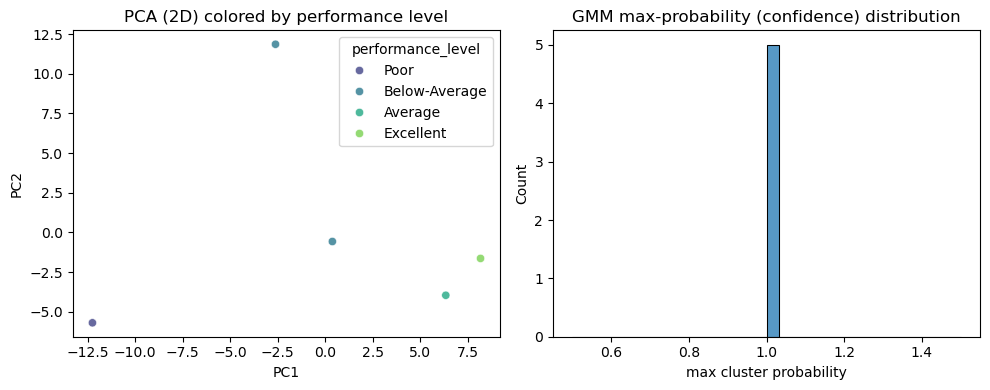


Per-level counts and mean proxy_score:


,count,mean,std
performance_level,,,
Poor,1,-0.541350,NaN
Below-Average,2,-0.020015,0.743524
Average,1,-0.012453,NaN
Excellent,1,0.593833,NaN


In [17]:
# Cell 8 - Visualization: 2D scatter of PCA-2 colored by performance level and cluster confidence histogram
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
if X_pca.shape[1] >= 2:
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['performance_level'], palette="viridis", alpha=0.8)
    plt.title("PCA (2D) colored by performance level")
    plt.xlabel("PC1"); plt.ylabel("PC2")
else:
    sns.scatterplot(x=X_pca[:,0], y=df['_proxy_score'], hue=df['performance_level'], palette="viridis", alpha=0.8)
    plt.xlabel("PC1"); plt.ylabel("proxy_score")

plt.subplot(1,2,2)
sns.histplot(df['gmm_confidence'], bins=30)
plt.title("GMM max-probability (confidence) distribution")
plt.xlabel("max cluster probability")
plt.tight_layout()
plt.show()

# Also display per-level summary table
print("\nPer-level counts and mean proxy_score:")
display(df.groupby('performance_level')['_proxy_score'].agg(['count','mean','std']).sort_values('mean'))


In [18]:
# Cell 9 - quick helper to map new samples using saved scaler + gmm + pca (example)
def apply_benchmark_to_new_features(new_df, feature_cols=candidate_cols, scaler_path=os.path.join(OUT_DIR,"scaler.pkl"),
                                   gmm_path=os.path.join(OUT_DIR,"gmm_model.pkl"), pca_path=os.path.join(OUT_DIR,"pca.pkl"),
                                   label_map=label_map):
    # new_df must include same feature columns
    newX = new_df[feature_cols].copy().astype(float).fillna(new_df[feature_cols].median())
    scaler = pd.read_pickle(scaler_path)
    gmm = pd.read_pickle(gmm_path)
    pca = pd.read_pickle(pca_path)
    Xs = scaler.transform(newX)
    labels_new = gmm.predict(Xs)
    probs_new = gmm.predict_proba(Xs).max(axis=1)
    # compute proxy score for ordering (use same function logic as above)
    new_proxy = cluster_ordering_score_matrix(new_df.assign(**newX))
    perf_levels = [label_map[int(l)] for l in labels_new]
    return pd.DataFrame({
        "gmm_label": labels_new,
        "gmm_confidence": probs_new,
        "performance_level": perf_levels,
        "proxy_score": new_proxy
    })

print("Helper defined: apply_benchmark_to_new_features(new_df) -> DataFrame")


Helper defined: apply_benchmark_to_new_features(new_df) -> DataFrame


In [19]:
# Cell 10 - final notes & saved artifacts listing
print("Done. Artifacts saved in:", OUT_DIR)
print(" - GMM model:", os.path.join(OUT_DIR, "gmm_model.pkl"))
print(" - scaler:", os.path.join(OUT_DIR, "scaler.pkl"))
print(" - pca:", os.path.join(OUT_DIR, "pca.pkl"))
print(" - labeled CSV:", os.path.join(OUT_DIR, "features_master_labeled_gmm4.csv"))
print(" - benchmark JSON:", BENCHMARK_JSON)
print("\nYou can now train the 4-class ML model using df['performance_level'] as the target.")


Done. Artifacts saved in: data\gmm_benchmark
 - GMM model: data\gmm_benchmark\gmm_model.pkl
 - scaler: data\gmm_benchmark\scaler.pkl
 - pca: data\gmm_benchmark\pca.pkl
 - labeled CSV: data\gmm_benchmark\features_master_labeled_gmm4.csv
 - benchmark JSON: data\gmm_benchmark\benchmark_gmm_4clusters.json

You can now train the 4-class ML model using df['performance_level'] as the target.
